In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv as csv

# from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.special import j1

In [2]:
# initialize everything

raw_xdata = []
raw_ydata = []
with open('fraunhofer.csv', mode='r') as f:
    read = csv.reader(f)
    next(read)
    for row in f:
        pair = row.split(',')
        raw_xdata.append(float(pair[0]))
        raw_ydata.append(float(pair[1][:-1]))

xdata = []
ydata = []

for i in range(28):
    xdata += [[x for x in raw_xdata[i::28]]]
    ydata += [[y for y in raw_ydata[i::28]]]

for i in range(28):
    xdata[i] = xdata[i][:3]
    ydata[i] = ydata[i][:3]

yerr = np.std(ydata, axis=1)

x_means = np.mean(xdata, axis=1)
y_means = np.mean(ydata, axis=1)
y_sems = yerr / np.sqrt(len(xdata[0]))

# print(ydata)

print(x_means)
print(y_means)
print(y_sems)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]
[ 5.30000000e-02  4.60000000e-02  1.70000000e-02 -1.30000000e-02
  1.33333333e-03  1.30000000e-01  4.53333333e-01  1.00666667e+00
  1.80000000e+00  2.80000000e+00  3.86666667e+00  4.83333333e+00
  5.46666667e+00  5.73333333e+00  5.50000000e+00  4.86666667e+00
  3.93333333e+00  2.90000000e+00  1.86666667e+00  1.06666667e+00
  5.56666667e-01  1.30000000e-01 -2.73333333e-02 -1.53333333e-02
  1.56666667e-02  5.63333333e-02  6.46666667e-02  4.73333333e-02]
[0.0004714  0.0020548  0.00286744 0.00124722 0.00392523 0.01247219
 0.0268052  0.04251361 0.04714045 0.04714045 0.05443311 0.02721655
 0.02721655 0.05443311 0.08164966 0.09813068 0.10886621 0.08164966
 0.05443311 0.05443311 0.09936838 0.01247219 0.0215836  0.00108866
 0.0057025  0.00098131 0.00222777 0.00313877]


### Fraunhofer Diffraction

We'd expect the intensity in our diffraction pattern to be described by the function
$$ I(\theta) = 4I_\textrm{max} \frac{[J_1(ka \sin \theta)]^2}{(ka \sin \theta)^2}. $$
Here are the fit considerations:

* We're not measuring intensity as a function of angle, we're measuring voltage as a function of position. So we'll be reporting a $V(x)$ in the data.
* We use the independent variable $x$ as a proxy for $a \sin \theta$, but the pattern's $\theta = 0$ isn't necessarily our $x = 0$. So we introduce the fit parameter $x_0$ as a constant offset.
* We'll introduce a constant of proportionality $A$ to take care of the coefficient in the theory.
* Our voltmeter has a constant offset, meaning $V = 0$ doesn't correspond to $I(\theta) = 0$. So we introduce a constant offset $V_0$.

In sum, we're fitting to the function
$$ V(x) = V_0 + A \frac{[J_1(k \cdot \frac{a}{r} (x - x_0))]^2}{(k \cdot \frac{a}{r} (x - x_0))^2}, $$
where $a$ is the radius of the diffraction aperture and $r$ is the aperture-detector distance.

[22, 13.1, -0.02, 0.5]
[23.02208157 13.01907308 -0.03928966  0.41392503]


(-0.25, 0.5)

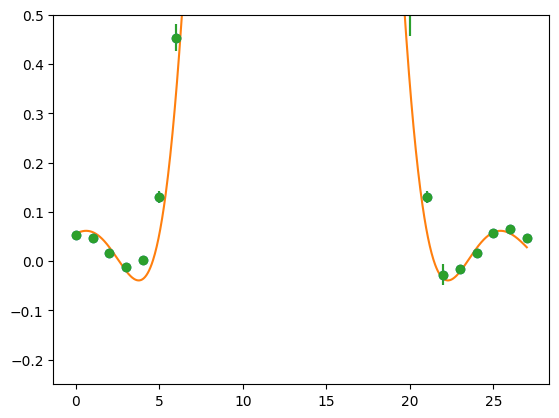

In [7]:
# perform the fit...

# k = 2*np.pi / (632.8e-6)   # 632.8 nm, expressed in mm
# diff_ap_radius = 50e-3  # 50 um, expressed in mm
# ap_ap_dist = 129e1   # 129 cm, expressed in mm
# a_r = diff_ap_radius / ap_ap_dist

# A = 25
def myfit(x, A, x0, V0, k):
    output = np.empty_like(x)
    is_small = np.isclose(x, x0)
    output[is_small] = V0 + A * 0.25
    output[~is_small] = V0 + A * ( j1(k*(x[~is_small]-x0)) / (k*(x[~is_small]-x0)) )**2
    return output

# A = 22
# x0 = 13.1
# V0 = -0.02
# k = 0.5

p0 = [22, 13.1, -0.02, 0.5]
(popt, pcov) = curve_fit(myfit, x_means, y_means, sigma=y_sems, absolute_sigma=True, p0=p0)
perr = np.sqrt(np.diag(pcov))

# ... and plot it!

plt.errorbar(x_means, y_means, y_sems, fmt='o', linestyle='')

xfit4plot = np.linspace(min(x_means), max(x_means), 1000)
yfit4plot = myfit(xfit4plot, * popt )
plt.plot(xfit4plot, yfit4plot, label = "fit")


print(p0)
print(popt)
# print(pcov)

# def f(x, A, x0, V0, k):
#     return V0 + A * ( j1(k*(x-x0)) / (k*(x-x0)) )**2

x_linspace = np.linspace(min(x_means), max(x_means), 1000)
# y_linspace = f(x_linspace, 22.75, 13.01, -0.02, 0.4)

plt.errorbar(x_means, y_means, y_sems, fmt='o', linestyle='')
# plt.plot(x_linspace, y_linspace)

# zoom into bottom
plt.ylim(-0.25, 0.5)


In [4]:
resids = y_means - myfit(x_means, * popt)
norm_resids = resids/yerr

chi_sq = sum(norm_resids**2)
print('chi_sq = ' + str(chi_sq))

M = len(x_means)
df = M - len(popt)
red_chi_sq = chi_sq / df

print('red_chi_sq = ' + str(red_chi_sq))

PTE = 1 - chi2.cdf(chi_sq, df=df)
print('PTE = ' + str(PTE))

chi_sq = 141.29642441197512
red_chi_sq = 5.8873510171656305
PTE = 0.0
